In [58]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import json
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

## Load Data

In [2]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Sta_ID', 'Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

In [3]:
# Load satellite variables, grouped by ecological role / process
satellite_vars = [
    
    # 1. Phytoplankton biomass (state variables)
    'CHL',        # Chlorophyll-a concentration (GlobColour)
    'C',          # Phytoplankton carbon biomass from BBP443 (GlobColour)

    # 2. Phytoplankton community composition (Phytoplankton Functional Types)
    'DIATO',      # Diatoms (GlobColour)
    'DINO',       # Dinoflagellates (GlobColour)
    'GREEN',      # Green algae (GlobColour)
    'HAPTO',      # Haptophytes (GlobColour)
    'PROCHLO',    # Prochlorococcus (GlobColour)
    'PROKAR',     # Other prokaryotes / cyanobacteria (GlobColour)

    # 3. Phytoplankton size structure / traits
    'MICRO',      # Microphytoplankton fraction (GlobColour)
    'NANO',       # Nanophytoplankton fraction (GlobColour)
    'PICO',       # Picophytoplankton fraction (GlobColour)
    'MESD',       # Mean equivalent spherical diameter (derived from MICRO/NANO/PICO; GlobColour)

    # 4. Phytoplankton physiology & stoichiometry
    'CHL:C',      # Chlorophyll-to-carbon ratio (GlobColour)

    # 5. Optical properties & particle environment
    'BBP',        # Particulate backscattering coefficient (GlobColour)
    'CDM',        # Colored detrital & dissolved organic matter absorption (GlobColour)
    'SPM',        # Suspended particulate matter (GlobColour)

    # 6. Ocean color reflectance (sensor-level spectral info)
    'RRS412',     # Remote sensing reflectance at 412 nm (GlobColour)
    'RRS443',     # Remote sensing reflectance at 443 nm (GlobColour)
    'RRS490',     # Remote sensing reflectance at 490 nm (GlobColour)
    'RRS555',     # Remote sensing reflectance at 555 nm (GlobColour)
    'RRS670',     # Remote sensing reflectance at 670 nm (GlobColour)

    # 7. Water clarity & light attenuation
    'KD490',      # Diffuse attenuation coefficient at 490 nm (GlobColour)
    'ZSD',        # Secchi disk depth (GlobColour)

    # 8. Light forcing
    'PAR',        # Photosynthetically available radiation (EarthData L3/L4)

    # 9. Physical environment & mixing
    'SST',        # Sea surface temperature (OSYSSEA)
    'MLD',        # Mixed layer depth (Global Ocean Physics Reanalysis; mlotst)

    # 10. Surface forcing & circulation
    'u10',        # 10 m zonal wind (ERA5 daily statistics)
    'v10',        # 10 m meridional wind (ERA5 daily statistics)
    'wind_stress_curl',  # Wind stress curl (Calculated from ERA5 daily statistics)

    # 11. Nutrient environment
    'no3',        # Nitrate concentration (Global Ocean Biogeochemistry Hindcast)
]

satellite_data = {}
for var in satellite_vars:
    var_data = xr.open_dataset(f'satellite_features/{var}.nc')
    satellite_data[var] = var_data

## Look for Redundant Satellite Variables

In [4]:
def correlation_matrix(satellite_data):
    corr_df = pd.DataFrame()

    for var, ds in satellite_data.items():
        if var not in satellite_vars:
            continue
        # Flatten npp and spatial dims into one long vector
        corr_df[var] = ds['value_0'].values.reshape(-1)  # (npp * lat * lon,)
    
    # Drop rows where any variable is NaN
    corr_df = corr_df.dropna()
    corr_matrix = corr_df.corr(method='spearman')
    
    # Convert correlation matrix to distance matrix
    distance_matrix = 1 - corr_matrix.abs()
    
    # Hierarchical clustering
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    
    # Get the ordering from the dendrogram
    dendro = dendrogram(linkage_matrix, no_plot=True)
    order = dendro['leaves']
    ordered_vars = corr_matrix.columns[order]
    
    # Reorder correlation matrix
    corr_reordered = corr_matrix.loc[ordered_vars, ordered_vars]
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        corr_reordered,
        ax=ax,
        cmap='RdBu_r',
        vmin=-1, vmax=1,
        center=0,
        annot=True,
        fmt='.2f',
        annot_kws={'size': 7},
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Pearson r'}
    )
    ax.set_title('Correlation Matrix (Satellite Variables)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_matrix

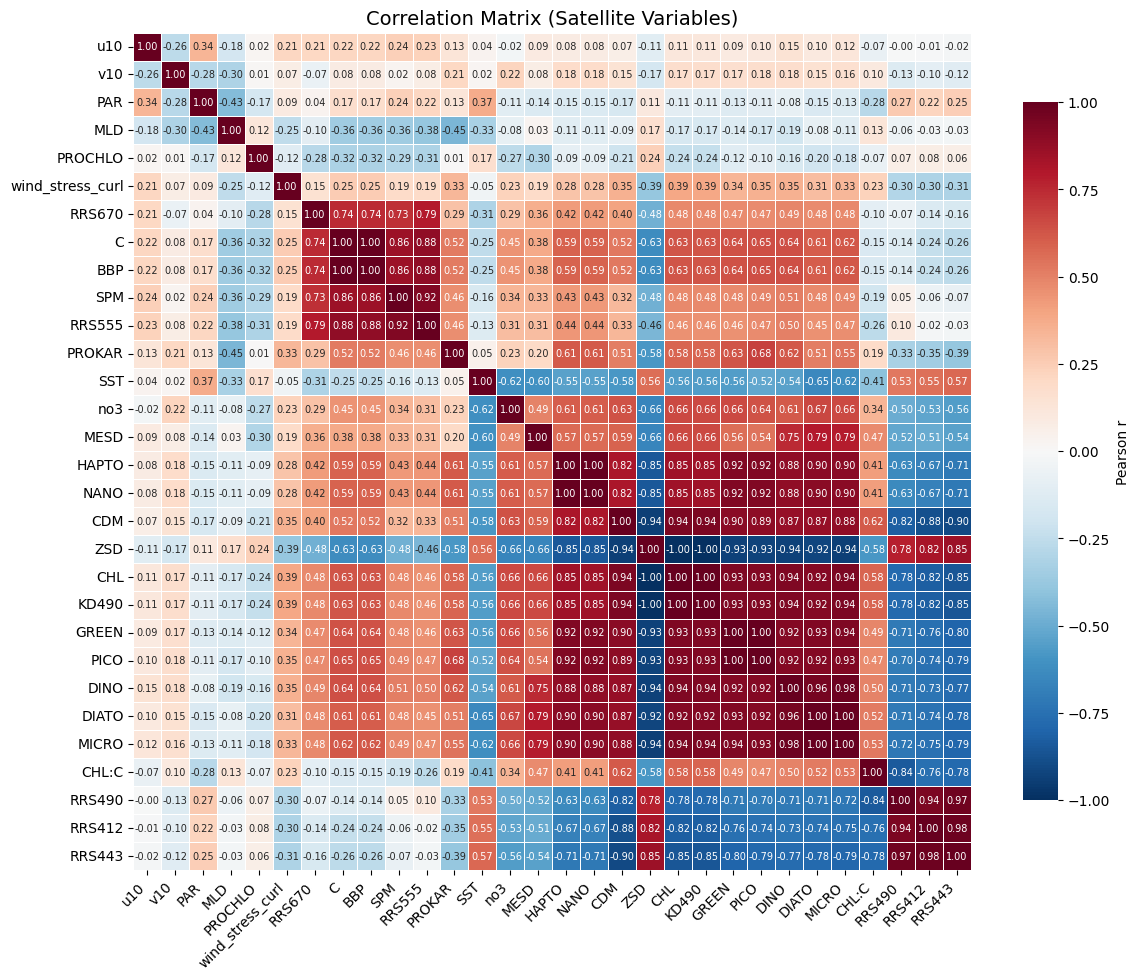

In [5]:
# Show correlations between satellite variables
corr_matrix = correlation_matrix(satellite_data)

## Choose Redundant Satellite Variables to Remove

In [6]:
print('Highly correlated variables:')
threshold = 0.95
pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

Highly correlated variables:
Pairs with correlation > 0.95:
NANO    HAPTO     1.000000
KD490   CHL       1.000000
BBP     C         1.000000
PICO    GREEN     0.996126
MICRO   DIATO     0.995467
RRS443  RRS412    0.983690
MICRO   DINO      0.977752
RRS490  RRS443    0.971305
DINO    DIATO     0.955961
ZSD     CHL      -1.000000
        KD490    -1.000000
dtype: float64


In [7]:
def plot_correlation(var1, var2, satellite_data, log_scale=False):
    x = satellite_data[var1]['value_0'].values.flatten()
    y = satellite_data[var2]['value_0'].values.flatten()
    
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]
    
    if log_scale:
        mask2 = (x > 0) & (y > 0)
        x, y = x[mask2], y[mask2]
    
    pearson_r = np.corrcoef(x, y)[0, 1]
    spearman_r, _ = stats.spearmanr(x, y)
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(x, y, s=2, alpha=0.2)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_title(
        f'{var1} vs {var2} (pixel-level {"log-log" if log_scale else ""})\n'
        f'Pearson r = {pearson_r:.3f}, Spearman r = {spearman_r:.3f}, N = {len(x):,}'
    )
    
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

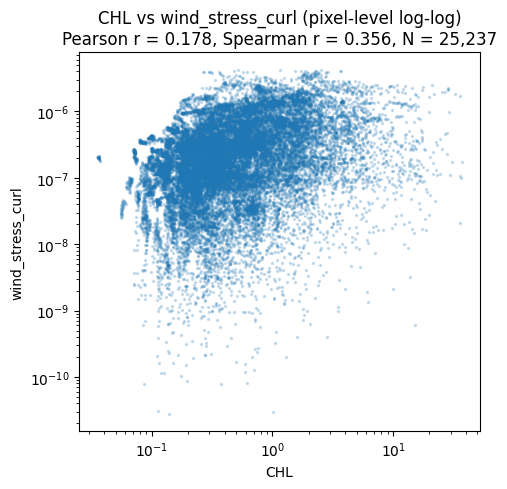

In [60]:
plot_correlation('CHL', 'wind_stress_curl', satellite_data, log_scale=True)

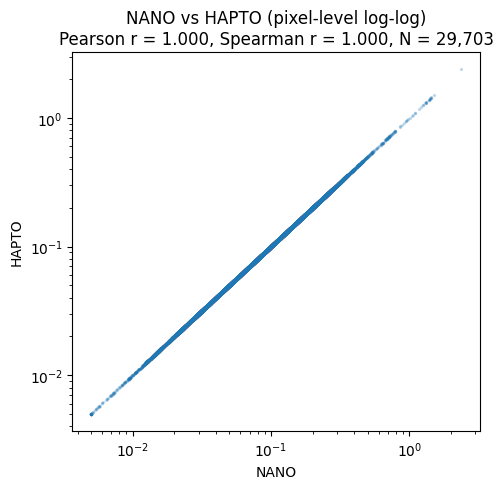

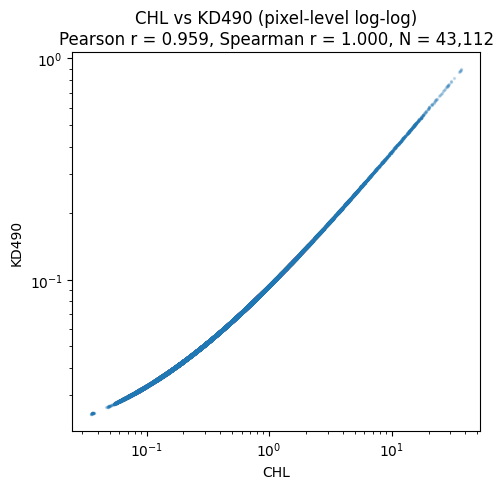

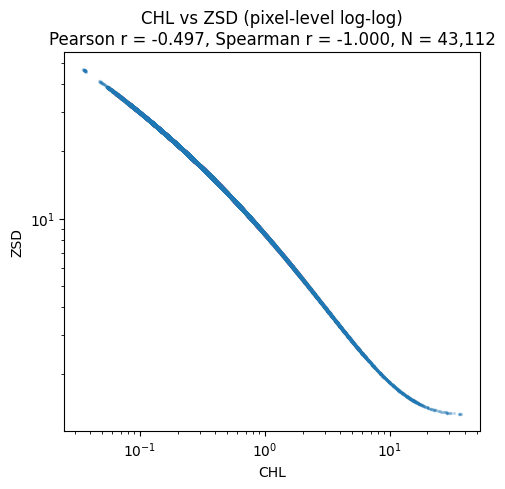

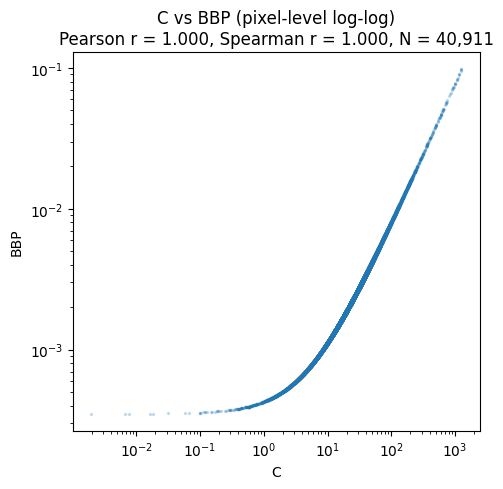

In [8]:
# Investigate specific pairs

## All these variable pairs are just rescalings of each other (no unique information for EDM models)
## Choosing to remove the following variables (somewhat arbitrary which one to choose):
##   - NANO
##   - KD490
##   - ZSD
##   - C

# NANO/HAPTO
plot_correlation('NANO', 'HAPTO', satellite_data, log_scale=True)

# CHL/KD490
plot_correlation('CHL', 'KD490', satellite_data, log_scale=True)

# CHL/ZSD
plot_correlation('CHL', 'ZSD', satellite_data, log_scale=True)

# C/BBP
plot_correlation('C', 'BBP', satellite_data, log_scale=True)

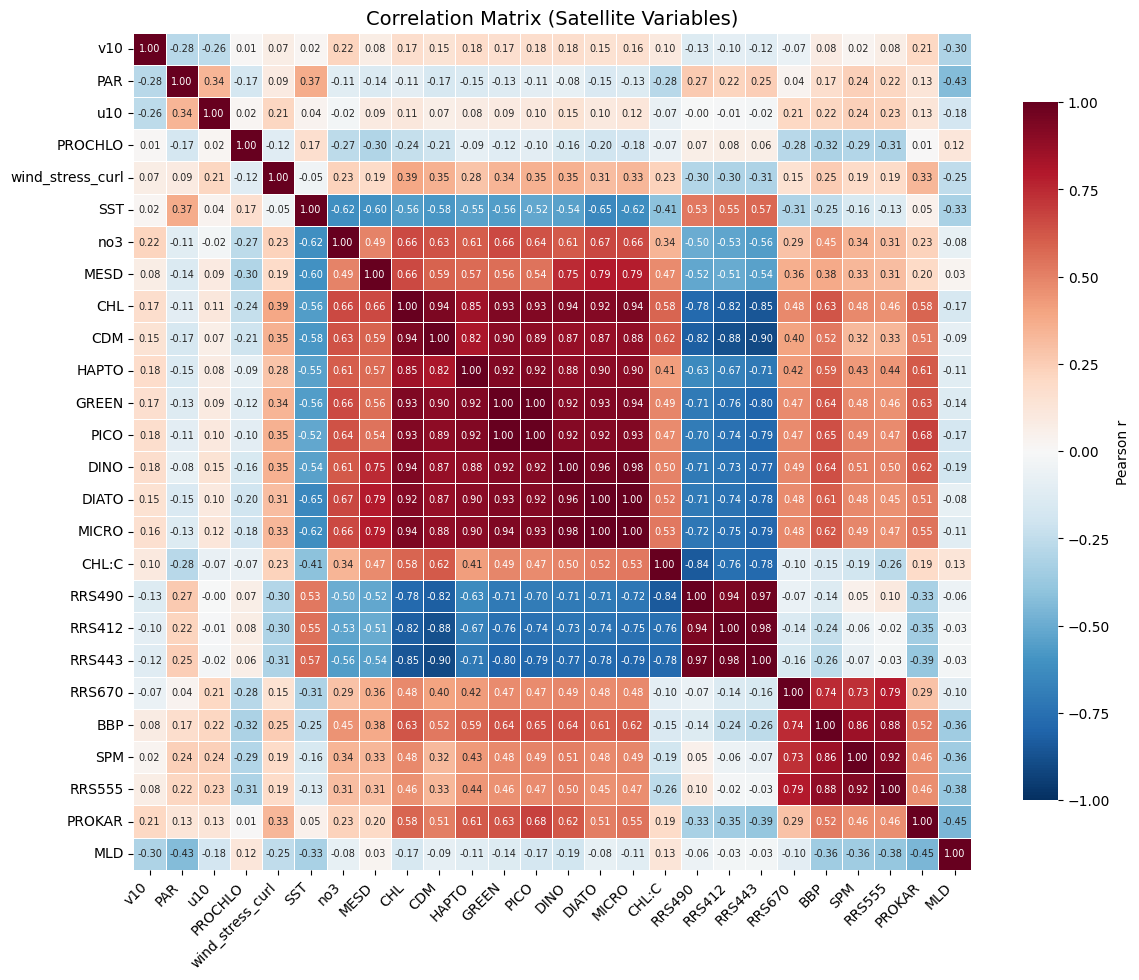

Highly correlated variables:
Pairs with correlation > 0.95:
PICO    GREEN     0.996126
MICRO   DIATO     0.995467
RRS443  RRS412    0.983690
MICRO   DINO      0.977752
RRS490  RRS443    0.971305
DINO    DIATO     0.955961
dtype: float64


In [9]:
# List of keys you want to remove
remove_keys = {'NANO', 'KD490', 'ZSD', 'C'}

# Create a new dictionary excluding those keys
satellite_data_new = {k: v for k, v in satellite_data.items() if k not in remove_keys}

# Show correlations between satellite variables (reduced dataset)
corr_matrix_new = correlation_matrix(satellite_data_new)

print('Highly correlated variables:')
threshold = 0.95
pairs = corr_matrix_new.where(np.triu(np.ones(corr_matrix_new.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

In [ ]:
# # Investigate specific pairs

# ## These variables have some unique information, but are very highly correlated (little unique information for EDM models)
# ## Choosing to remove the following variables (somewhat arbitrary which one to choose):
# ##   - PICO
# ##   - MICRO
# ##   - RRS412
# ##   - RRS490

# # PICO/GREEN
# plot_correlation('PICO', 'GREEN', satellite_data, log_scale=True)

# # MICRO/DIATO
# plot_correlation('MICRO', 'DIATO', satellite_data, log_scale=True)

# # RRS443/RRS412
# plot_correlation('RRS443', 'RRS412', satellite_data, log_scale=True)

# # RRS443/RRS490
# plot_correlation('RRS443', 'RRS490', satellite_data, log_scale=True)

In [ ]:
# # List of keys you want to remove
# remove_keys = {'NANO', 'KD490', 'ZSD', 'C'} #, 'PICO', 'MICRO', 'RRS412', 'RRS490'}

# # Create a new dictionary excluding those keys
# satellite_data_new = {k: v for k, v in satellite_data.items() if k not in remove_keys}

# # Show correlations between satellite variables (reduced dataset)
# corr_matrix_new = correlation_matrix(satellite_data_new)

# print('Highly correlated variables:')
# threshold = 0.95
# pairs = corr_matrix_new.where(np.triu(np.ones(corr_matrix_new.shape), k=1).astype(bool))
# pairs = pairs.unstack().dropna()
# high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
# print(f"Pairs with correlation > {threshold}:")
# print(high_corr)

We are left with a reduced dataset of satellite variables that contain mostly non-redundant information for nearest-neighbor searches. This will make the code more efficient as it will reduce the number of possible embeddings of satellite data.

## Now Remove Redundant Lags

In [10]:
def correlation_matrix_lagged(satellite_data):
    data_dict = {} # Use a dictionary for speed

    for var_name, ds in satellite_data.items():
        for data_var in ds.data_vars:
            if 'date' in data_var:
                continue
            
            col_name = f"{var_name}_{data_var}"
            # Flatten and store in dictionary
            data_dict[col_name] = ds[data_var].values.reshape(-1)
    
    # Create DataFrame all at once
    corr_df = pd.concat({k: pd.Series(v) for k, v in data_dict.items()}, axis=1)#.dropna()
    
    # Calculate Spearman (Rank) Correlation
    # This is better for satellite data as it's less sensitive to outliers
    corr_matrix = corr_df.rank().corr(method='pearson')
    
    # --- Hierarchical Clustering (Same as your original logic) ---
    distance_matrix = 1 - corr_matrix.abs()
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    dendro = dendrogram(linkage_matrix, no_plot=True)
    order = dendro['leaves']
    ordered_vars = corr_matrix.columns[order]
    corr_reordered = corr_matrix.loc[ordered_vars, ordered_vars]
    
    # Plotting
    plt.figure(figsize=(35, 25)) # Increased size for more variables
    sns.heatmap(corr_reordered, cmap='RdBu_r', vmin=-1, vmax=1, center=0,
                square=True, linewidths=0.1, annot=False) # Annot=False to avoid clutter
    plt.title('Lagged & Feature Correlation Matrix', fontsize=16)
    plt.show()

    return corr_matrix

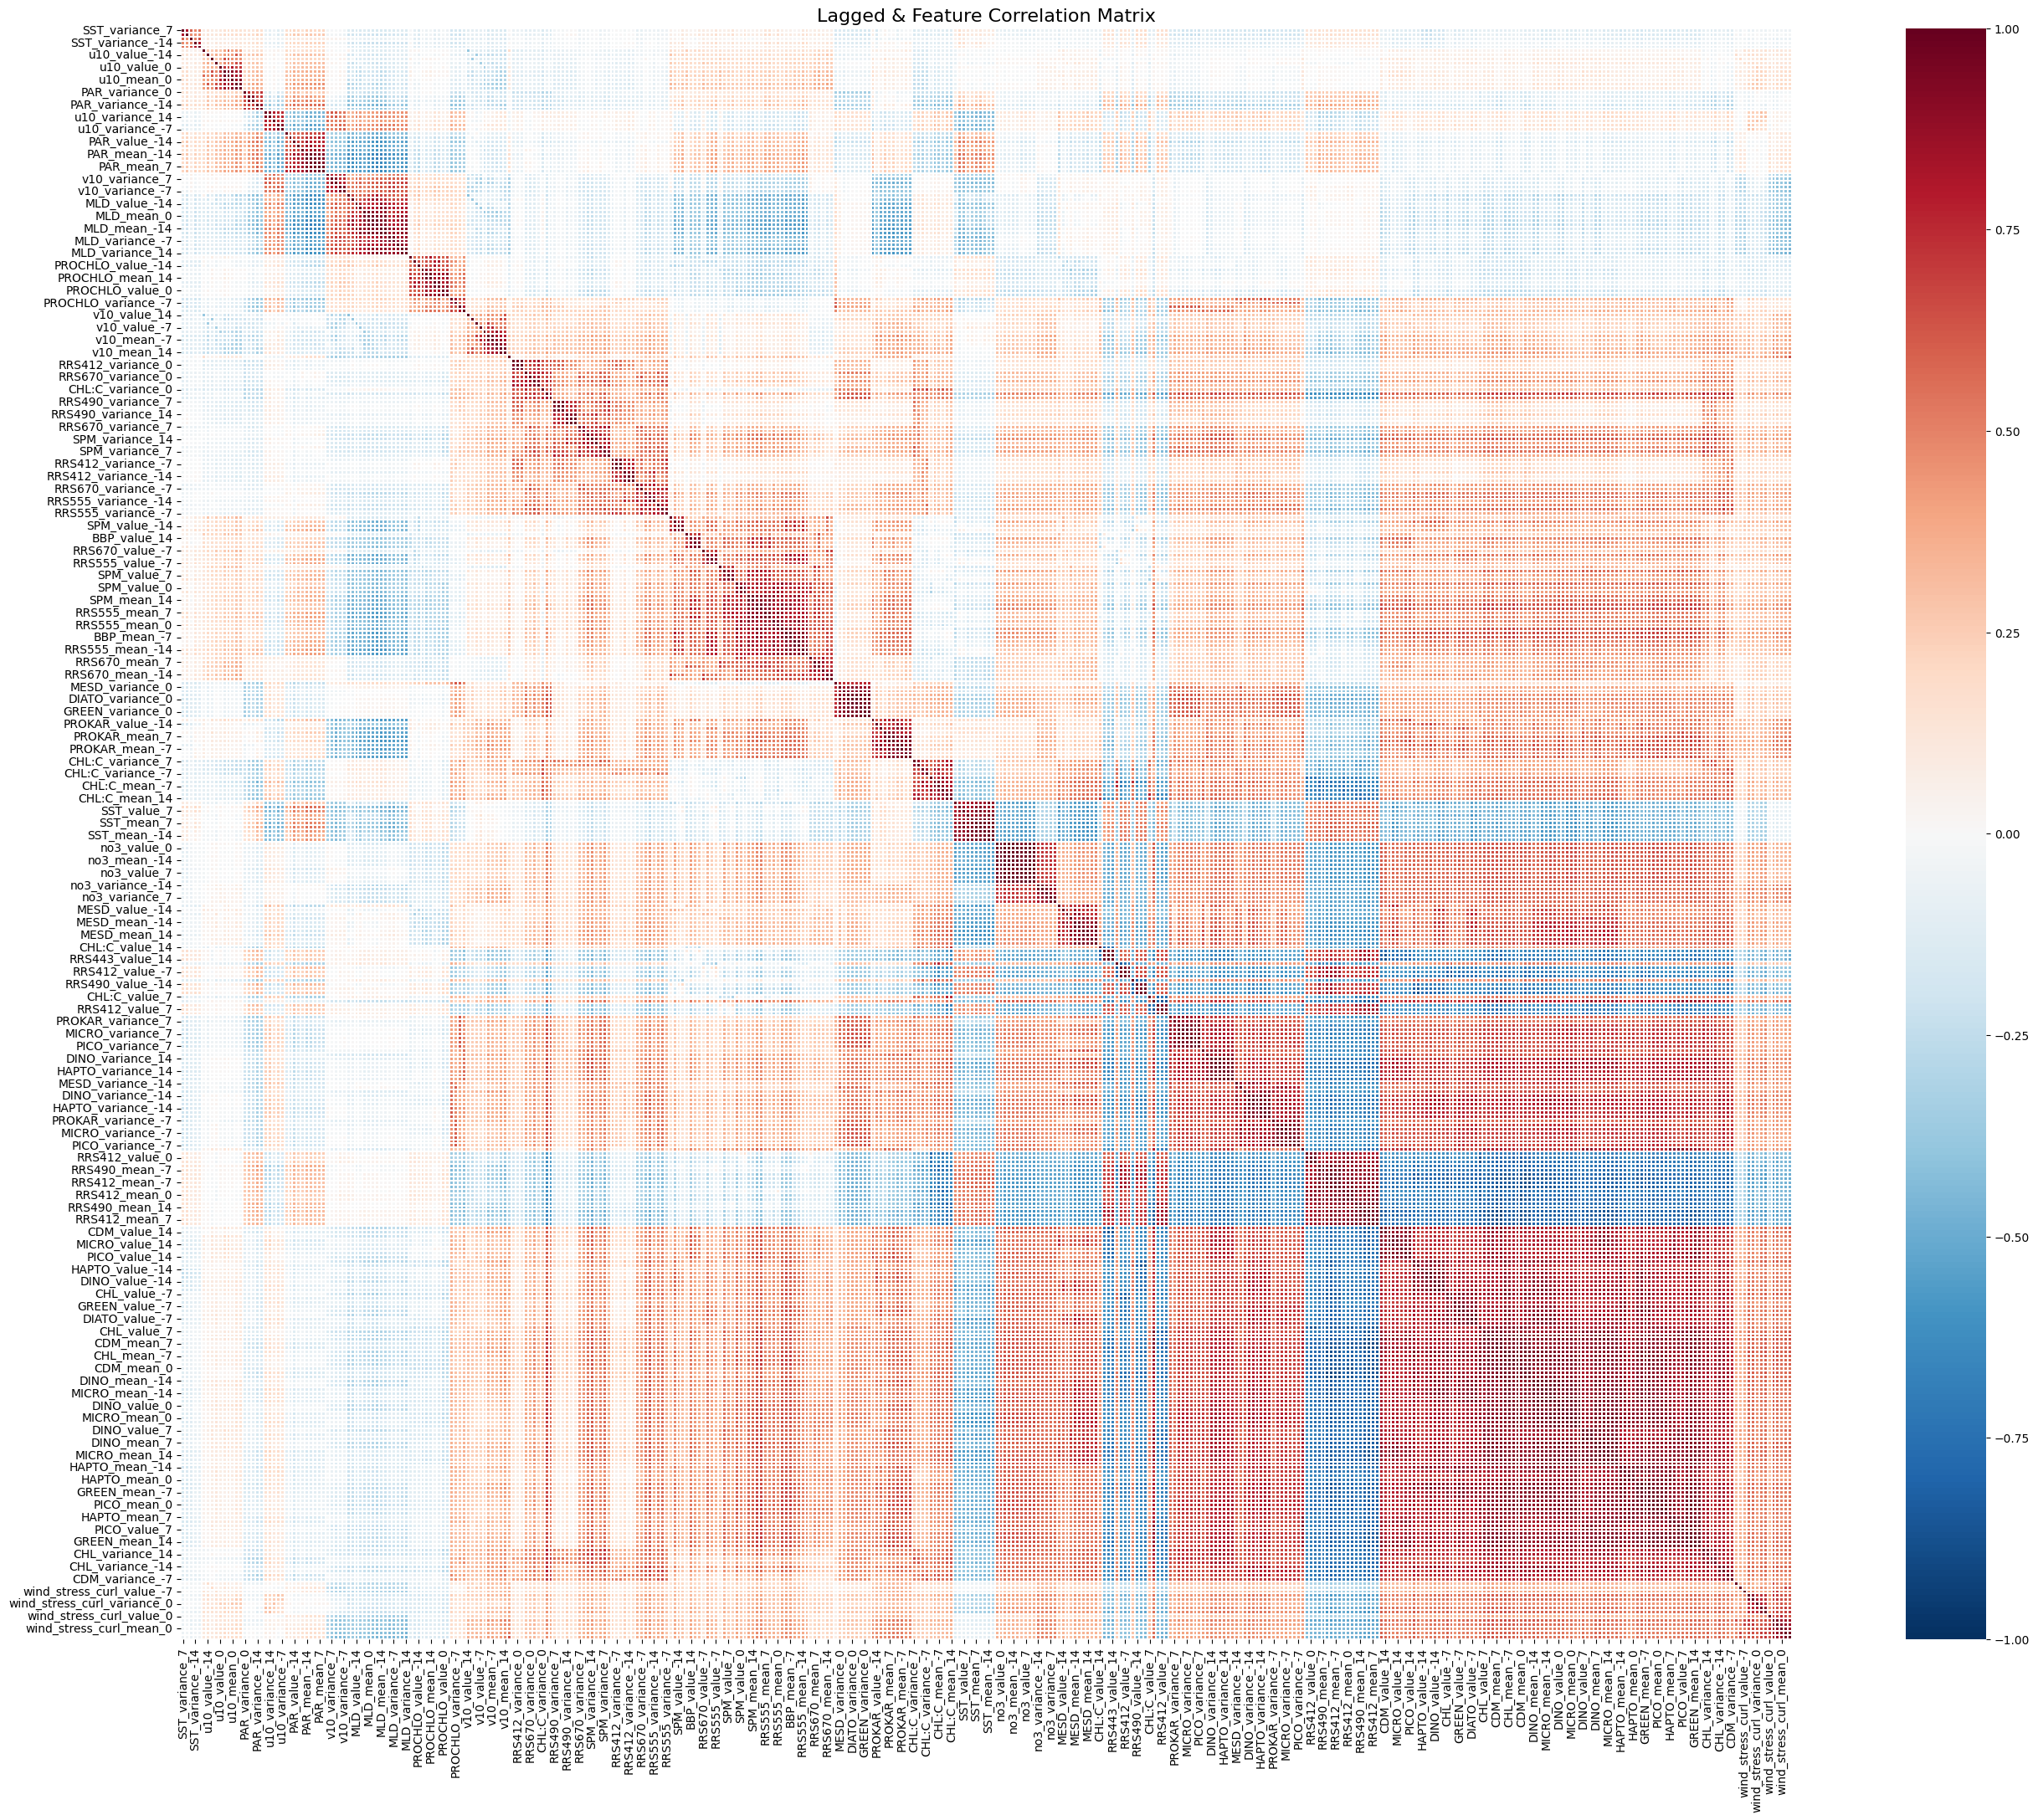

corr_matrix.shape: (390, 390)
Highly correlated variables:
Pairs with correlation > 0.9:
no3_mean_0         no3_value_0           0.999556
PICO_variance_-14  GREEN_variance_-14    0.998823
PICO_variance_-7   GREEN_variance_-7     0.998630
PICO_variance_14   GREEN_variance_14     0.998364
PICO_variance_7    GREEN_variance_7      0.998360
                                           ...   
RRS443_mean_7      CDM_mean_7           -0.917564
RRS412_mean_-14    CDM_mean_-14         -0.918425
RRS412_mean_14     CDM_mean_14          -0.920265
RRS443_mean_-14    CDM_mean_-14         -0.923466
RRS443_mean_14     CDM_mean_14          -0.925688
Length: 1248, dtype: float64


In [11]:
# Show correlations between satellite variables (reduced dataset)
corr_matrix = correlation_matrix_lagged(satellite_data_new)

print('corr_matrix.shape:', corr_matrix.shape)

print('Highly correlated variables:')
threshold = 0.90
pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

In [12]:
# Get remove list

def get_pruning_list(high_corr_series):
    # Get all unique variables involved in high correlations
    all_vars = set()
    for pair in high_corr_series.index:
        all_vars.add(pair[0])
        all_vars.add(pair[1])

    def get_clean_prefix(name):
        # Finds the part before _mean_, _value_, or _variance_
        for marker in ['_mean_', '_value_', '_variance_']:
            if marker in name:
                return name.split(marker)[0]
        return name.split('_')[0] # Fallback
    
    # Define a scoring system based on your hierarchy
    # Higher score = more likely to KEEP
    def score_variable(var_name):
        score = 0
        # 1. Prefer Mean over Value
        if '_mean_' in var_name: score += 100
        elif '_value_' in var_name: score += 50
        
        # 2. Prefer Current (0) over Lagged
        # 3. Prefer Smaller lag over Larger lag
        if '_0' in var_name: score += 20
        elif '_7' in var_name or '_-7' in var_name: score += 10
        elif '_14' in var_name or '_-14' in var_name: score += 5
        return score

    # Group variables by their base prefix (everything before the first underscore)
    variables_by_prefix = {}
    for var in all_vars:
        p = get_clean_prefix(var)
        if p not in variables_by_prefix:
            variables_by_prefix[p] = []
        variables_by_prefix[p].append(var)

    to_remove = []
    for prefix, group in variables_by_prefix.items():
        if len(group) > 1:
            # Sort by score: Best variable stays at index 0
            sorted_group = sorted(group, key=score_variable, reverse=True)
            to_remove.extend(sorted_group[1:])
            print(f"Refined Prefix: {prefix:17} | Kept: {sorted_group[0]:25} | Dropped: {len(sorted_group[1:])}")

    return list(set(to_remove))

# # Apply the function to your high_corr pairs
remove_list = get_pruning_list(high_corr)

Refined Prefix: DIATO             | Kept: DIATO_mean_0              | Dropped: 14
Refined Prefix: RRS490            | Kept: RRS490_mean_0             | Dropped: 14
Refined Prefix: HAPTO             | Kept: HAPTO_mean_0              | Dropped: 14
Refined Prefix: GREEN             | Kept: GREEN_mean_0              | Dropped: 14
Refined Prefix: RRS555            | Kept: RRS555_mean_0             | Dropped: 9
Refined Prefix: PICO              | Kept: PICO_mean_0               | Dropped: 14
Refined Prefix: BBP               | Kept: BBP_mean_0                | Dropped: 5
Refined Prefix: PAR               | Kept: PAR_mean_0                | Dropped: 4
Refined Prefix: CHL               | Kept: CHL_mean_0                | Dropped: 13
Refined Prefix: PROKAR            | Kept: PROKAR_mean_0             | Dropped: 8
Refined Prefix: MICRO             | Kept: MICRO_mean_0              | Dropped: 14
Refined Prefix: MESD              | Kept: MESD_mean_0               | Dropped: 6
Refined Prefix: PROCH

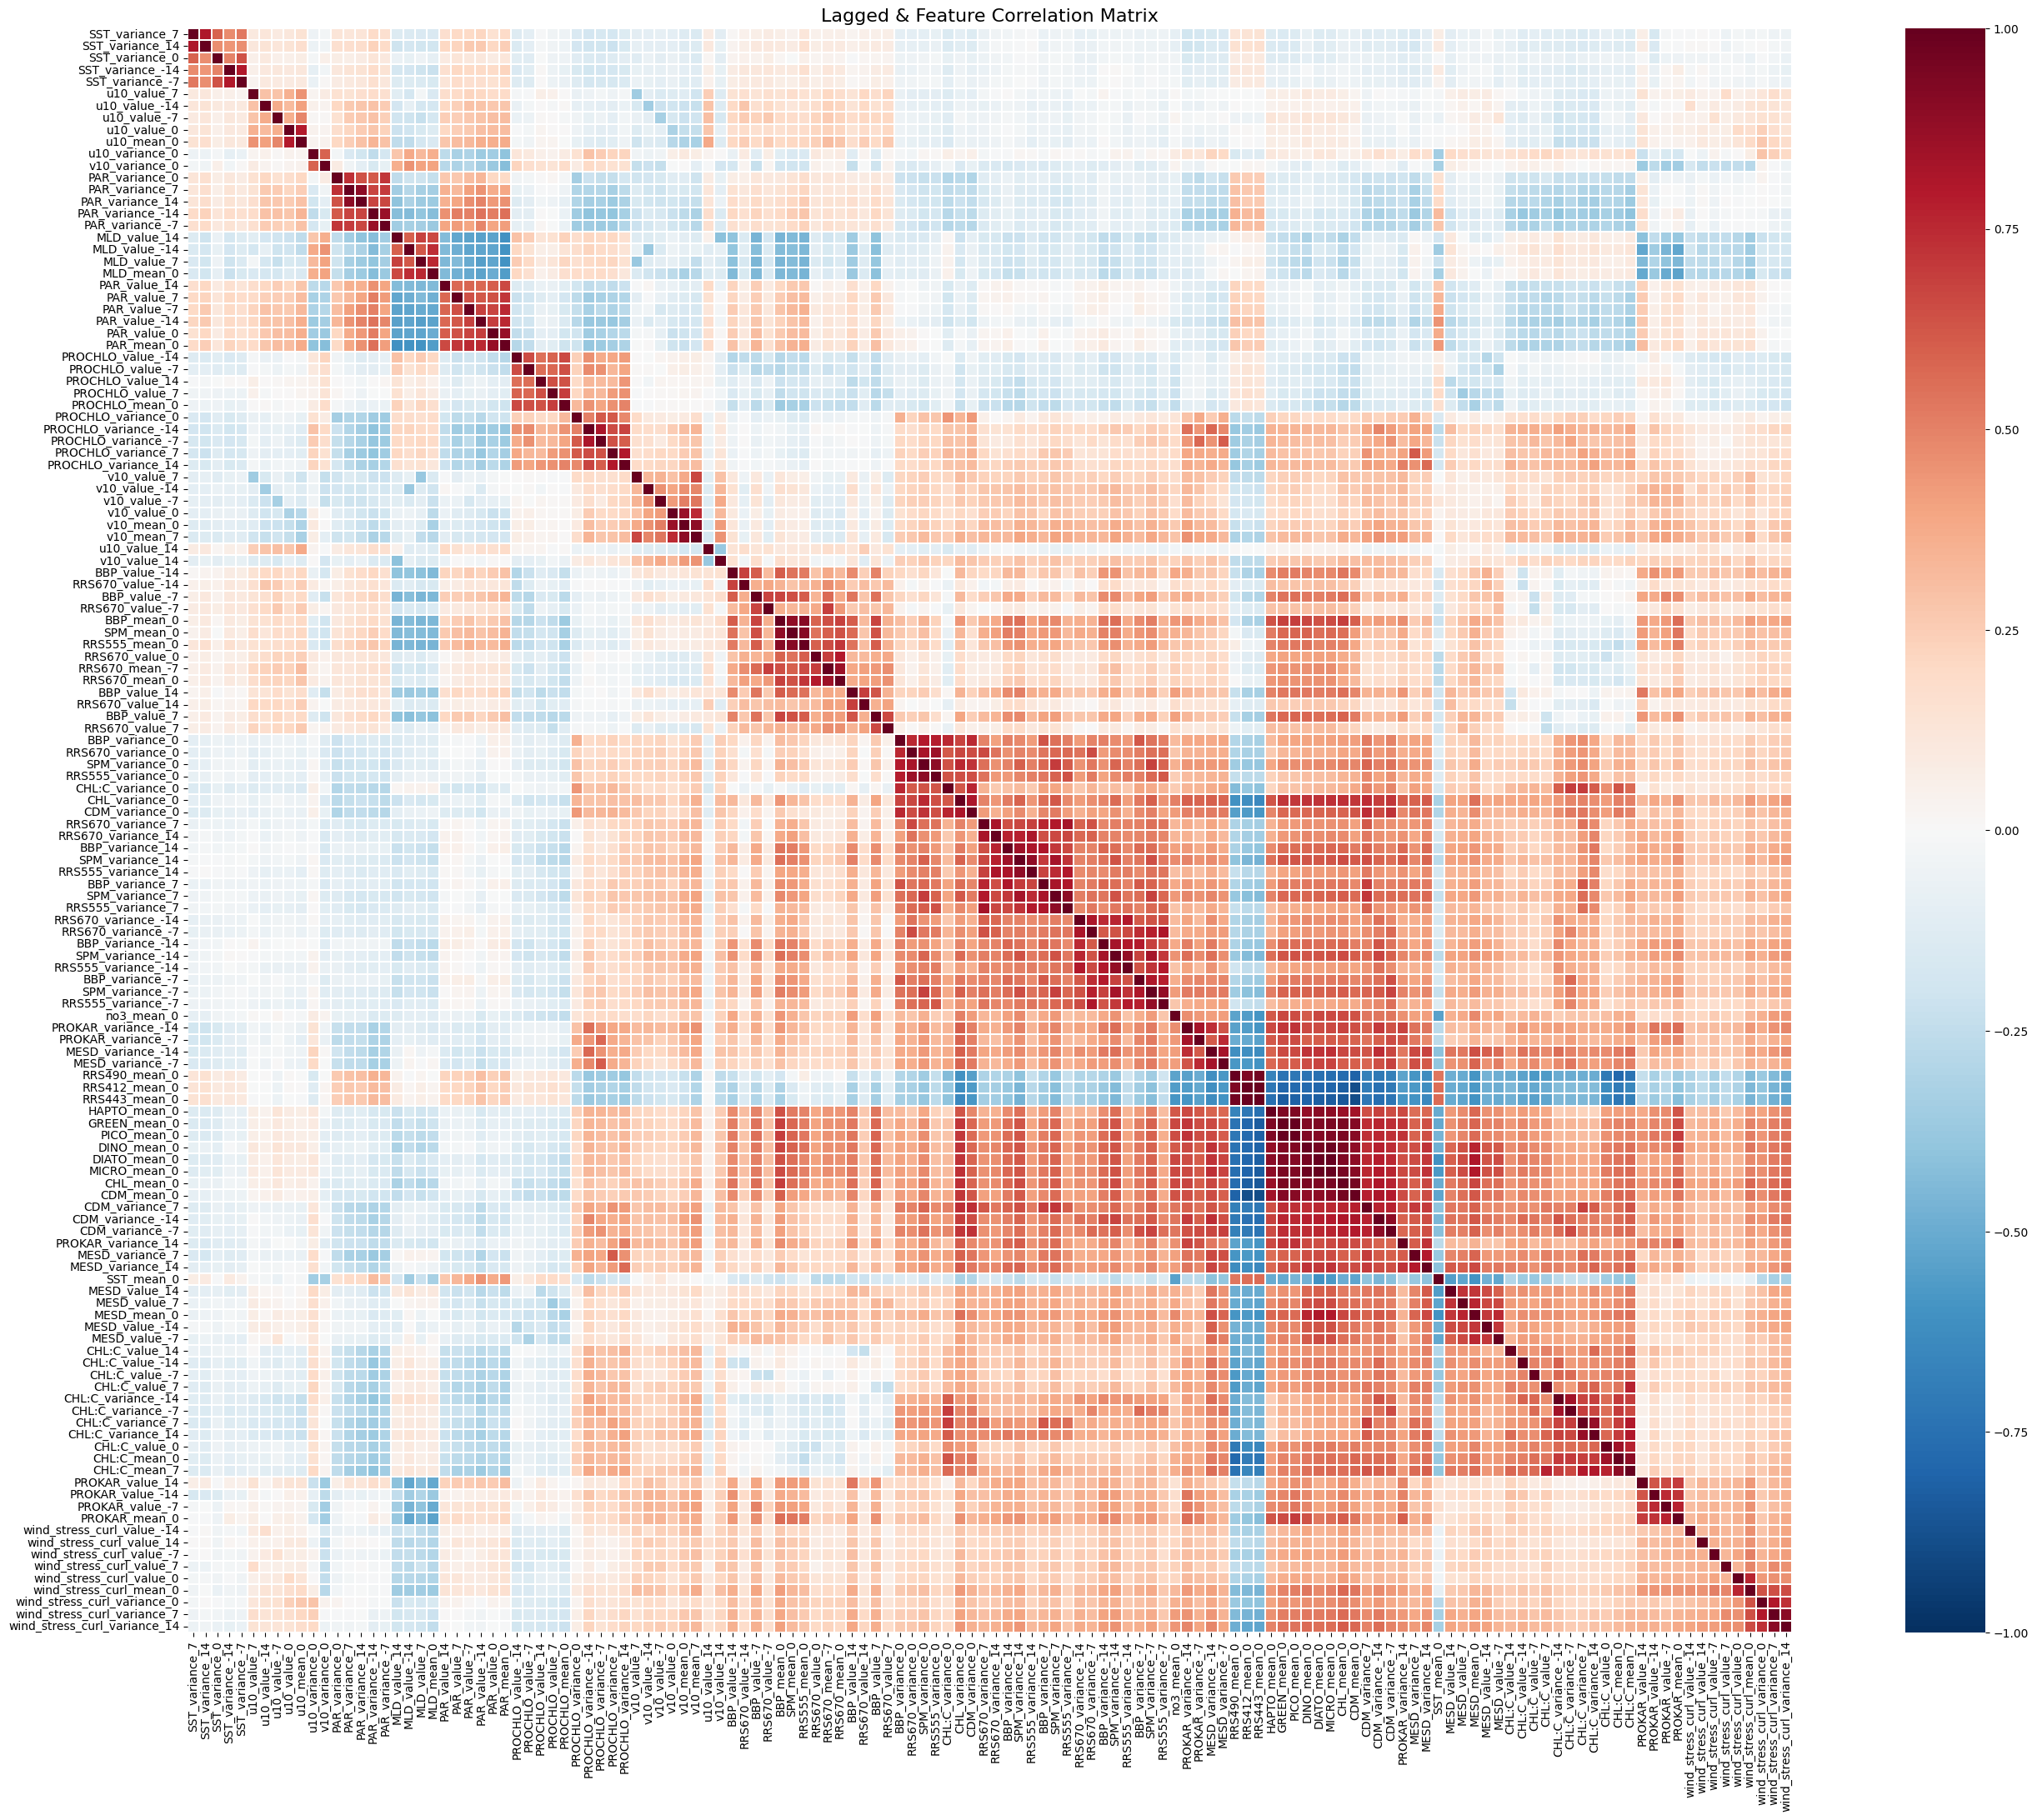

Highly correlated variables:
Pairs with correlation > 0.9:
PICO_mean_0    GREEN_mean_0     0.996482
MICRO_mean_0   DIATO_mean_0     0.996252
RRS443_mean_0  RRS412_mean_0    0.985408
MICRO_mean_0   DINO_mean_0      0.979371
RRS490_mean_0  RRS443_mean_0    0.968440
DINO_mean_0    DIATO_mean_0     0.960348
CDM_mean_0     CHL_mean_0       0.955367
MICRO_mean_0   CHL_mean_0       0.946743
DINO_mean_0    CHL_mean_0       0.942595
GREEN_mean_0   CHL_mean_0       0.941833
MICRO_mean_0   GREEN_mean_0     0.939433
PICO_mean_0    CHL_mean_0       0.938311
RRS490_mean_0  RRS412_mean_0    0.935699
DIATO_mean_0   CHL_mean_0       0.934167
HAPTO_mean_0   GREEN_mean_0     0.933244
PICO_mean_0    MICRO_mean_0     0.932258
GREEN_mean_0   DIATO_mean_0     0.931697
PICO_mean_0    HAPTO_mean_0     0.930912
               DINO_mean_0      0.925824
GREEN_mean_0   DINO_mean_0      0.924884
PICO_mean_0    DIATO_mean_0     0.921749
CDM_mean_0     GREEN_mean_0     0.919331
RRS555_mean_0  SPM_mean_0       0.91169

In [13]:
# Assuming satellite_data_new is your current dictionary
for item in remove_list:
    # 1. Find which dictionary key matches the start of this remove_item
    # We sort keys by length (longest first) to ensure 'wind_stress_curl' 
    # matches before 'wind' does.
    matched_key = None
    for k in sorted(satellite_data_new.keys(), key=len, reverse=True):
        if item.startswith(f"{k}_"):
            matched_key = k
            break
    
    if matched_key:
        # 2. Extract the internal variable name by removing the key and the joiner underscore
        # e.g., 'wind_stress_curl_mean_14' -> 'mean_14'
        var_to_drop = item[len(matched_key)+1:]
        
        # 3. Drop from the xarray dataset
        if var_to_drop in satellite_data_new[matched_key].data_vars:
            satellite_data_new[matched_key] = satellite_data_new[matched_key].drop_vars(var_to_drop)


# Show correlations between satellite variables (reduced dataset)
corr_matrix = correlation_matrix_lagged(satellite_data_new)

print('Highly correlated variables:')
threshold = 0.90
pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

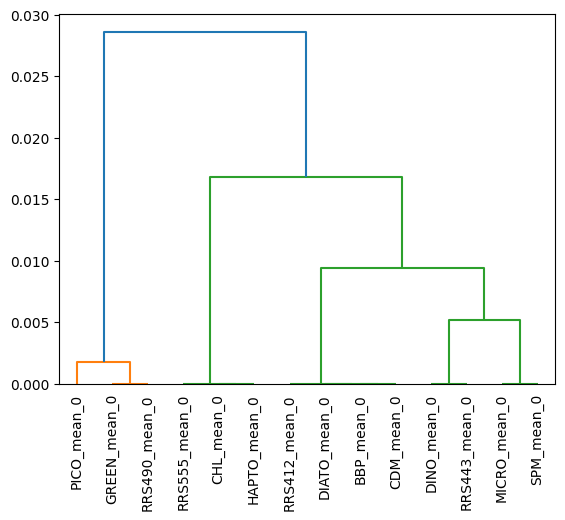

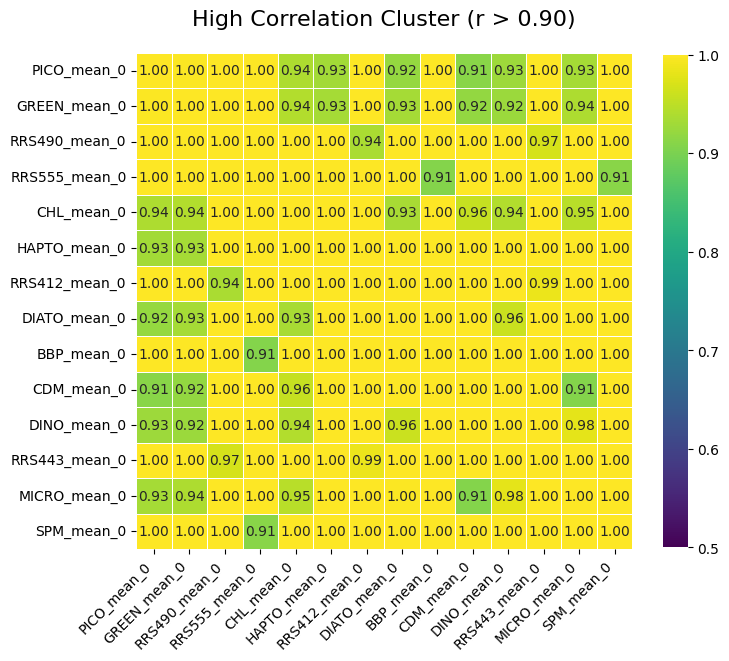

In [35]:
# Visualize highly correlated pairs for manual pruning
# 1. Identify all unique variables in the high-correlation list
high_corr_vars = sorted(list(set([v for pair in high_corr.keys() for v in pair])))

# 2. Create a sub-matrix for visualization
sub_corr = pd.DataFrame(1.0, index=high_corr_vars, columns=high_corr_vars)
for (v1, v2), val in high_corr.items():
    sub_corr.loc[v1, v2] = val
    sub_corr.loc[v2, v1] = val

# 3. Perform hierarchical clustering to group similar clusters
distance_matrix = 1 - sub_corr.abs()
linkage_matrix = linkage(squareform(distance_matrix), method='average')
dendro = dendrogram(linkage_matrix, labels=high_corr_vars,
                   leaf_rotation=90.,  # Rotates labels for better visibility
                    leaf_font_size=10., # Font size
                                   )#, no_plot=True)
ordered_vars = [high_corr_vars[i] for i in dendro['leaves']]
sub_corr_ordered = sub_corr.loc[ordered_vars, ordered_vars]

# 4. Plotting
plt.figure(figsize=(8,8))
sns.heatmap(sub_corr_ordered, annot=True, fmt=".2f", cmap='viridis', vmin=0.5, vmax=1.0, square=True, linewidths=0.5,cbar_kws={"shrink": .8})

plt.title('High Correlation Cluster (r > 0.90)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.show()

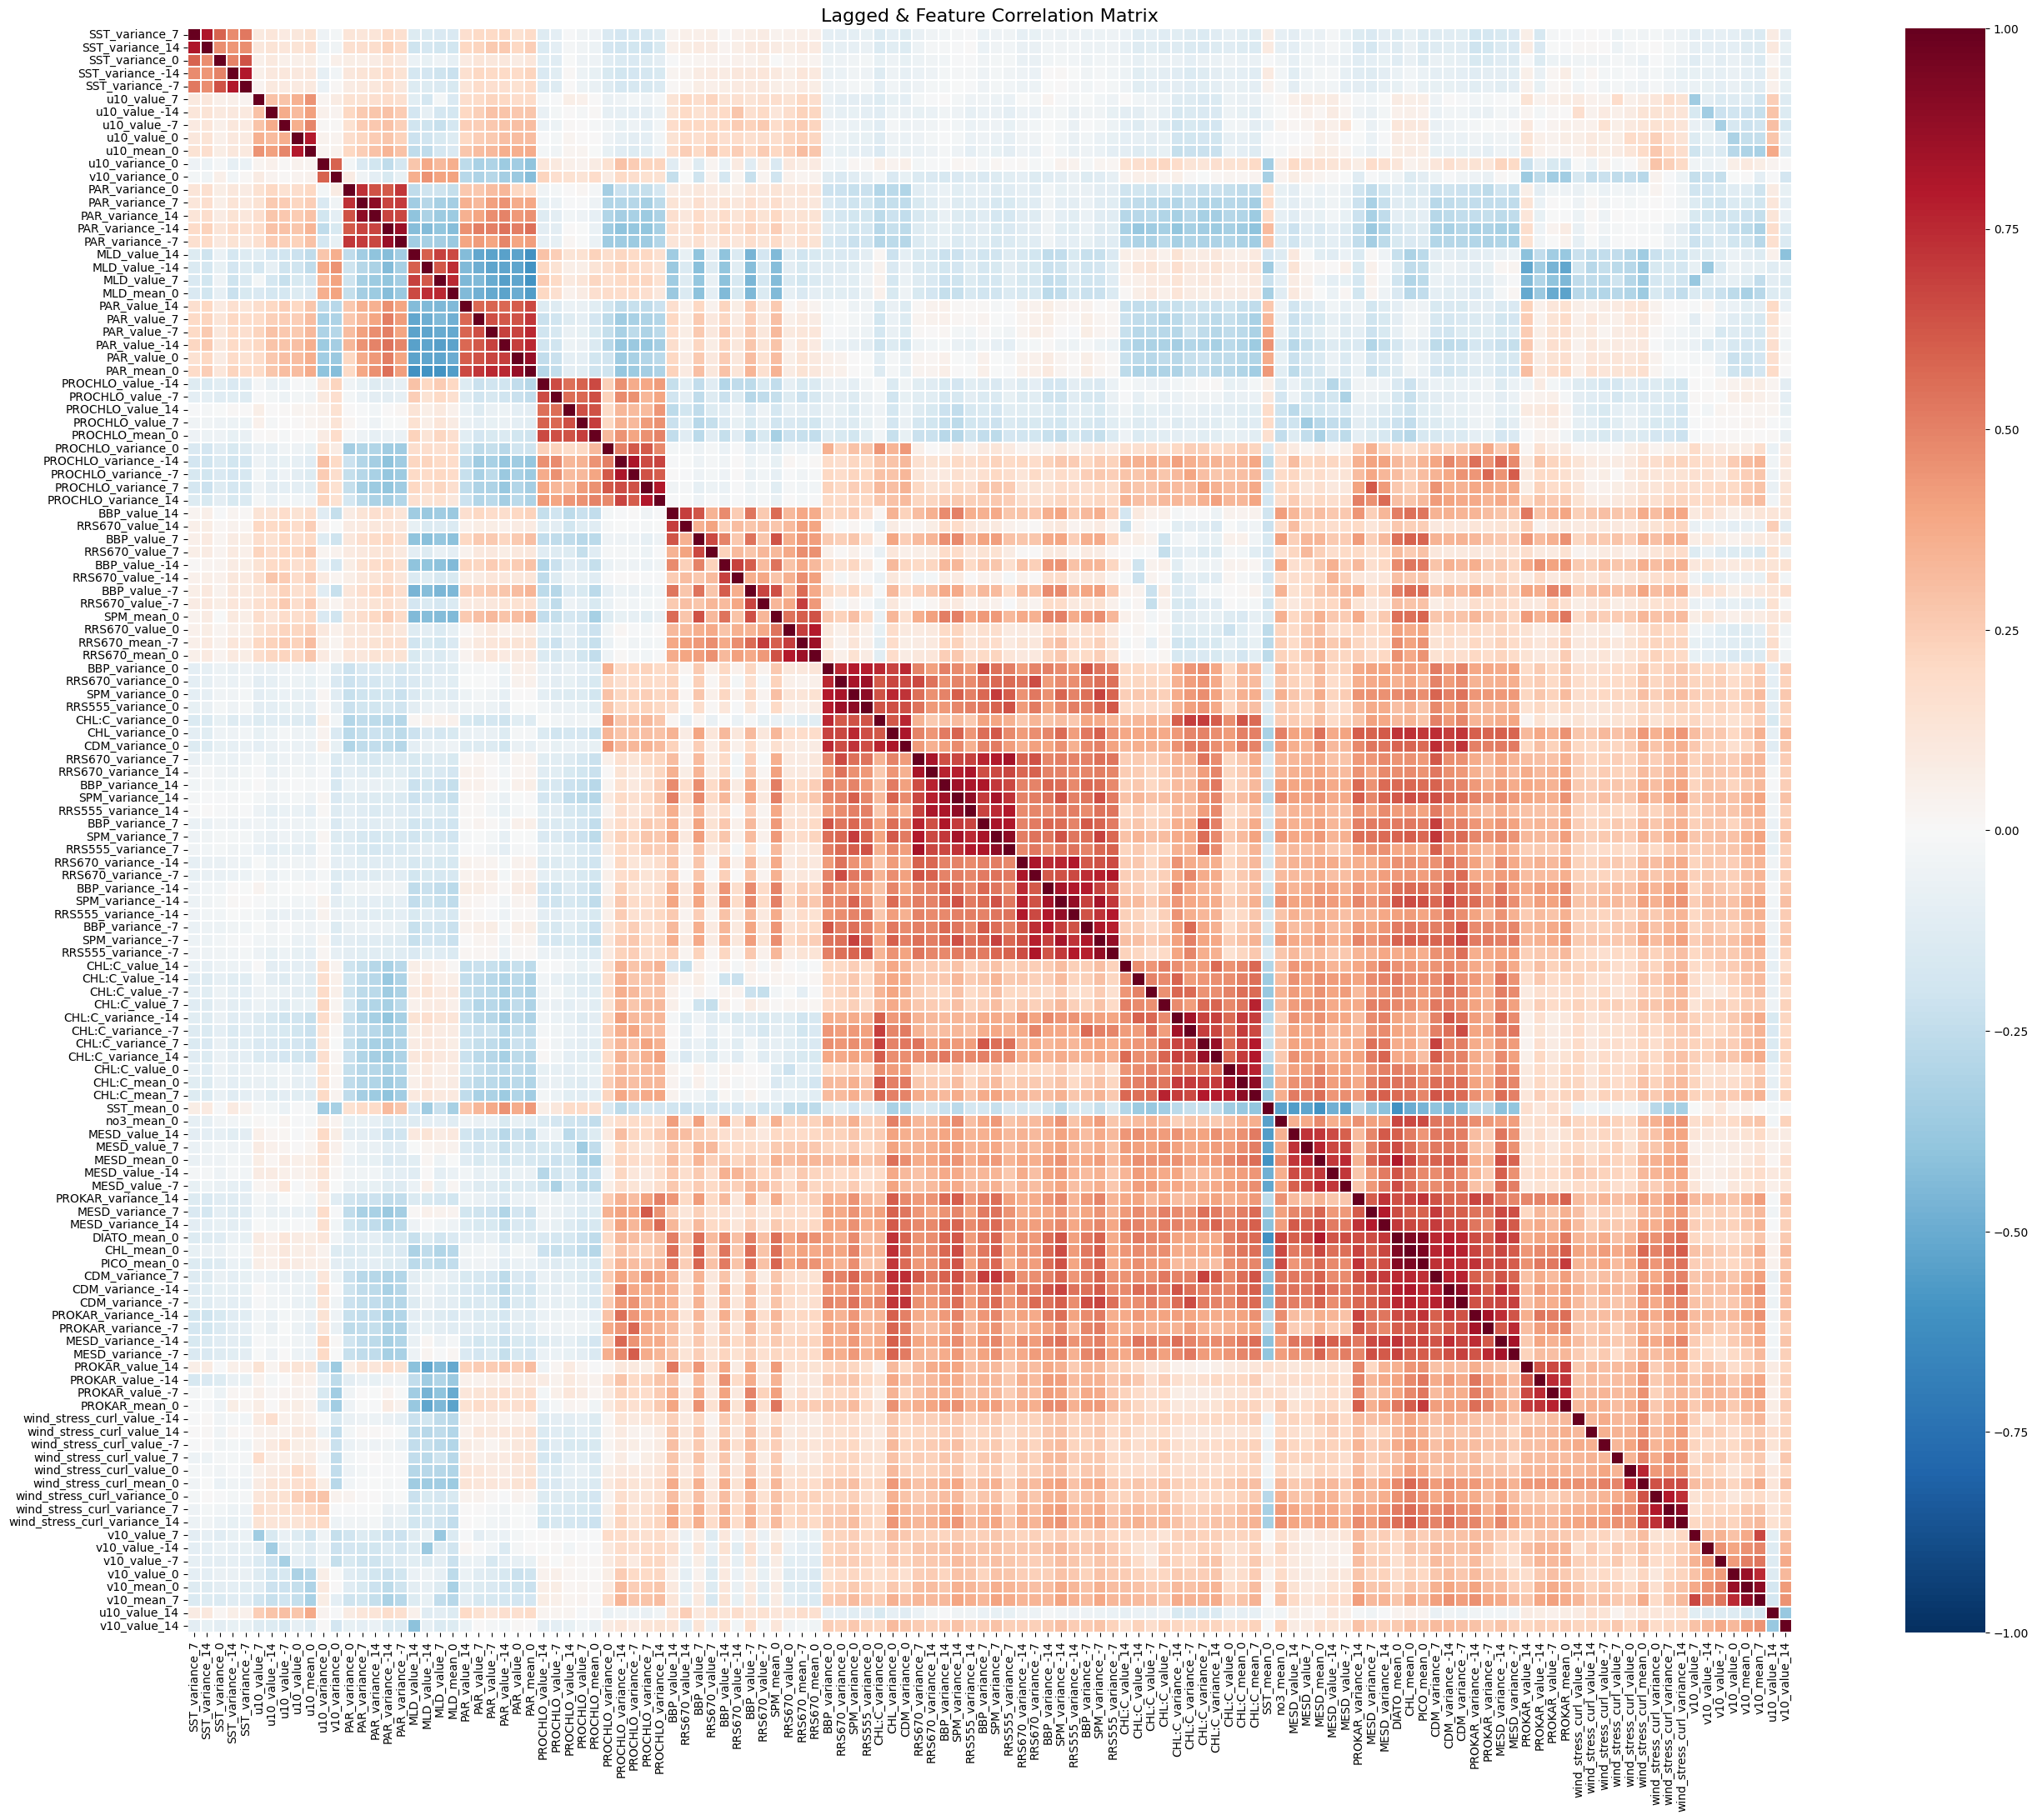

Highly correlated variables:
Pairs with correlation > 0.9:
PICO_mean_0   CHL_mean_0      0.938311
DIATO_mean_0  CHL_mean_0      0.934167
PICO_mean_0   DIATO_mean_0    0.921749
dtype: float64


In [36]:
# Final step: manual removal (based on dendrogram)
manual_remove_list = ['GREEN_mean_0', 'RRS490_mean_0', 'RRS555_mean_0', 'HAPTO_mean_0', 'RRS412_mean_0', 'BBP_mean_0',
                      'CDM_mean_0', 'DINO_mean_0', 'RRS443_mean_0', 'MICRO_mean_0']

for item in manual_remove_list:
    matched_key = None
    for k in sorted(satellite_data_new.keys(), key=len, reverse=True):
        if item.startswith(f"{k}_"):
            matched_key = k
            break
    if matched_key:
        var_to_drop = item[len(matched_key)+1:]
        if var_to_drop in satellite_data_new[matched_key].data_vars:
            satellite_data_new[matched_key] = satellite_data_new[matched_key].drop_vars(var_to_drop)

# Show correlations between satellite variables (reduced dataset)
corr_matrix = correlation_matrix_lagged(satellite_data_new)

print('Highly correlated variables:')
threshold = 0.90
pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = pairs.unstack().dropna()
high_corr = pairs[abs(pairs) > threshold].sort_values(ascending=False)
print(f"Pairs with correlation > {threshold}:")
print(high_corr)

In [44]:
print(f'final {corr_matrix.shape[0]} predictors:')
print(corr_matrix.columns.tolist())

final 124 predictors:
['CHL_mean_0', 'CHL_variance_0', 'DIATO_mean_0', 'PROCHLO_value_-14', 'PROCHLO_value_-7', 'PROCHLO_value_7', 'PROCHLO_value_14', 'PROCHLO_mean_0', 'PROCHLO_variance_-14', 'PROCHLO_variance_-7', 'PROCHLO_variance_0', 'PROCHLO_variance_7', 'PROCHLO_variance_14', 'PROKAR_value_-14', 'PROKAR_value_-7', 'PROKAR_value_14', 'PROKAR_mean_0', 'PROKAR_variance_-14', 'PROKAR_variance_-7', 'PROKAR_variance_14', 'PICO_mean_0', 'MESD_value_-14', 'MESD_value_-7', 'MESD_value_7', 'MESD_value_14', 'MESD_mean_0', 'MESD_variance_-14', 'MESD_variance_-7', 'MESD_variance_7', 'MESD_variance_14', 'CHL:C_value_-14', 'CHL:C_value_-7', 'CHL:C_value_0', 'CHL:C_value_7', 'CHL:C_value_14', 'CHL:C_mean_0', 'CHL:C_mean_7', 'CHL:C_variance_-14', 'CHL:C_variance_-7', 'CHL:C_variance_0', 'CHL:C_variance_7', 'CHL:C_variance_14', 'BBP_value_-14', 'BBP_value_-7', 'BBP_value_7', 'BBP_value_14', 'BBP_variance_-14', 'BBP_variance_-7', 'BBP_variance_0', 'BBP_variance_7', 'BBP_variance_14', 'CDM_variance_

In [59]:
# Save reduced list of satellite features
predictor_list = corr_matrix.columns.tolist()

with open("../data/final_predictors.json", "w") as f:
    json.dump(predictor_list, f)